In [ ]:
# default_exp core

# Bayesian AB Testing Simulation

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

### Expected loss
$$ E[L](?) = \int_0^1 \int_0^1 L(\lambda_A, \lambda_B, ?) P(\lambda_A, \lambda_B)d\lambda_B d\lambda_A $$

where the loss function is defined as
$L(\lambda_A, \lambda_B, ?) =$ amount of uplift that one can expect to loss by choosing variant $?$
$$L(\lambda_A, \lambda_B, A) = max(\lambda_B - \lambda_A, 0)$$
$$L(\lambda_A, \lambda_B, B) = max(\lambda_A - \lambda_B, 0)$$


In [71]:

def plot_dist(dist, samples=2000):
    plt.hist(dist.rvs(samples), density=True)

In [13]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

In [23]:
a = 1; b = 1
priorA = beta(a, b)
priorB = beta(a, b)

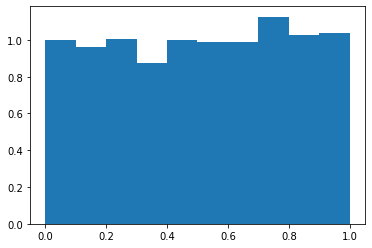

In [24]:
plot_dist(priorA)

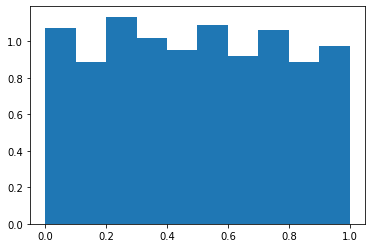

In [25]:
plot_dist(priorB)

In [83]:
samples = [5000, 10000, 20000, 40000, 80000]

In [84]:
a_ctr = 0.1
a_samples = 50000
a_converted = a_samples * a_ctr

b_ctr = 0.099
b_samples = 50700
b_converted = b_samples * b_ctr

a_converted, b_converted

converted =  500.0 495.0
converted =  1000.0 990.0
converted =  2000.0 1980.0
converted =  4000.0 3960.0
converted =  8000.0 7920.0


In [29]:
posteriorA = beta(a + a_converted, b + (a_samples - a_converted))
posteriorB = beta(a + b_converted, b + (b_samples - b_converted))

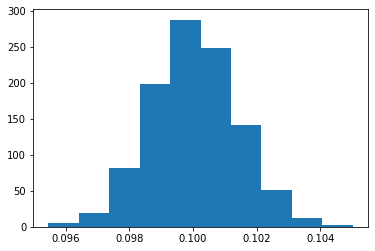

In [30]:
plot_dist(posteriorA)

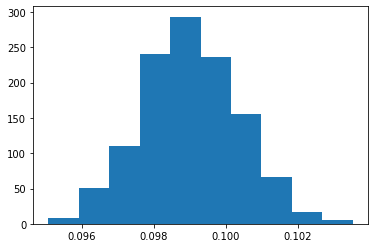

In [31]:
plot_dist(posteriorB)

In [36]:
posteriorA.rvs(1)

array([0.09669381])

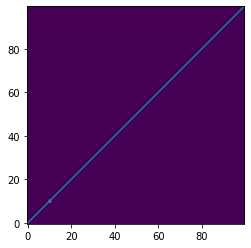

In [70]:
x = np.linspace(0,1, num=100)
post_A_values = np.array([posteriorA.pdf(_x) for _x in x])
post_B_values = np.array([posteriorB.pdf(_x) for _x in x])
joint_posterior = np.zeros(shape=(100, 100))
for i in range(100):
    for j in range(100):
        joint_posterior[i, j] = post_A_values[i] * post_B_values[j]

plt.imshow(joint_posterior, origin='lower')
plt.plot(range(100), range(100));

In [47]:
posteriorA.pdf(0.1)

297.3549554007636

In [113]:
def loss(i, j, var, bins=100):
    # 0.01 is the width of each value, since we did 100 samples, width is 1/100 = 0.01
    width = 1/bins
    if var == 'A':
        return max(j*width - i*width, 0.0)
    if var == 'B':
        return max(i*width - j*width, 0.0)
    

In [122]:
def get_expected_loss(variant, joint_posterior):
    assert joint_posterior.shape[0] == joint_posterior.shape[1]
    expected_loss = 0.0
    for i in range(joint_posterior.shape[0]):
        for j in range(joint_posterior.shape[1]):
            expected_loss += joint_posterior[i,j] * loss(i,j, variant, bins=joint_posterior.shape[0])
    return expected_loss

In [120]:
from scipy.stats import norm, binom
import pandas as pd

In [201]:
# generalize code
def simulate(baseline_ctr, lift, step=500, n_step=20):
    samples = np.arange(0, step*n_step, step=step)
    a_ctr = baseline_ctr
    b_ctr = a_ctr * (1+lift)
    prior_alpha = 1
    prior_beta = 1

    expected_losses = {
        'A': [],
        'B': []
    }
    col = 3
    row = (len(samples)+1) // col + 1
    row_size = 3
    plt.figure(figsize=(15,row_size*row))
    plt.suptitle(f'Simulation with Params = (a_ctr:{a_ctr:.2f}, b_ctr:{b_ctr:.2f})', fontsize=20)
    for fig_i, sample in enumerate(samples):
        plt.subplot(row, col,fig_i+1)
        a_samples = sample
        a_converted = binom.rvs(a_samples, a_ctr)

        b_ctr = a_ctr * (1+lift)
        b_samples = sample
        b_converted = binom.rvs(b_samples, b_ctr)

        posterior_a = beta(prior_alpha + a_converted, prior_beta + (a_samples - a_converted))
        posterior_b = beta(prior_alpha + b_converted, prior_beta + (b_samples - b_converted))

        # increase num for higher resolution, but slower simulation
        x = np.linspace(0,1, num=500)
        post_a_values = np.array([posterior_a.pdf(_x) for _x in x])
        post_b_values = np.array([posterior_b.pdf(_x) for _x in x])
        joint_posterior = np.zeros(shape=(len(post_a_values), len(post_b_values)))
        for i in range(len(post_a_values)):
            for j in range(len(post_b_values)):
                joint_posterior[i, j] = post_a_values[i]/len(post_a_values) * post_b_values[j]/len(post_b_values)

        expected_loss_a = get_expected_loss('A', joint_posterior)
        expected_loss_b = get_expected_loss('B', joint_posterior)
        expected_losses['A'].append(expected_loss_a)
        expected_losses['B'].append(expected_loss_b)
        ctr_y_lim=0.2
        y_lim = int(ctr_y_lim * len(joint_posterior))
        plt.imshow(joint_posterior[:y_lim,:y_lim].T, origin='lower')
        plt.xlabel('A CTR')
        plt.ylabel('B CTR')
        plt.plot(range(y_lim), range(y_lim))
        plt.title(f'Samples/var={sample}, EL_A={expected_loss_a:.2f}, EL_B={expected_loss_b:.2f}, \n a_ctr={a_ctr:.2f}, b_crt={b_ctr:.2f}, conversion diff={b_converted-a_converted}')

    pd.DataFrame(expected_losses, index=samples).plot(ax=plt.subplot(row, col, fig_i+2), ylim=(0,0.05))
    plt.title('Expected Losses')
    plt.ylabel('CTR')
    plt.xlabel('Impressions');
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

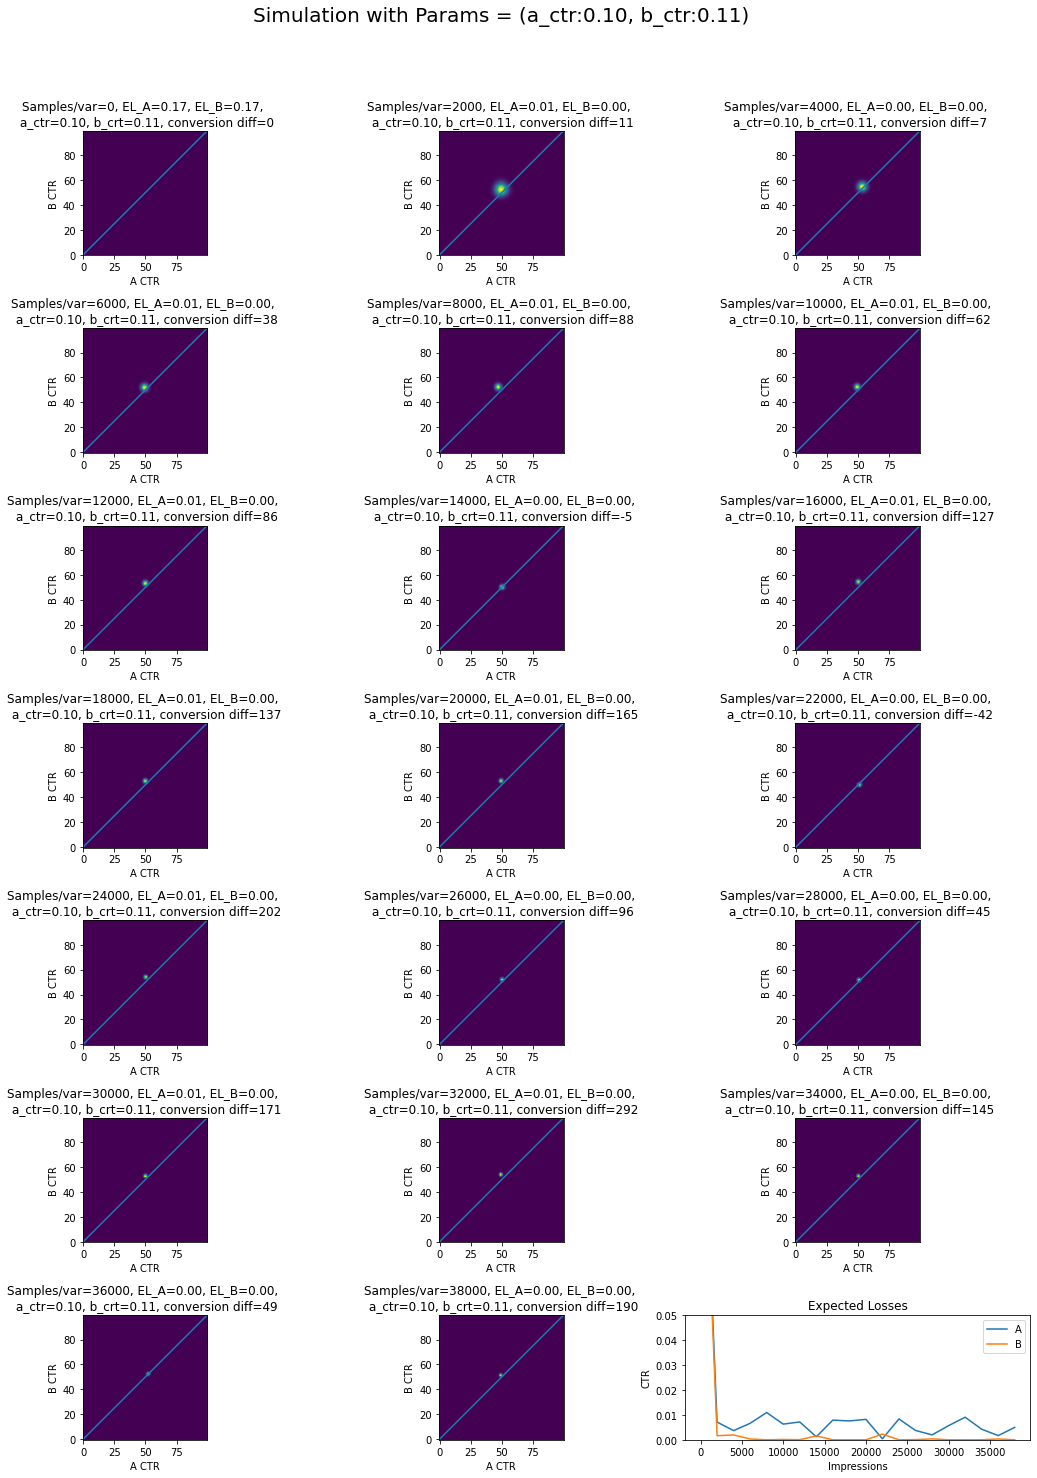

In [202]:
simulate(baseline_ctr=0.1, lift=0.05, step=2000)

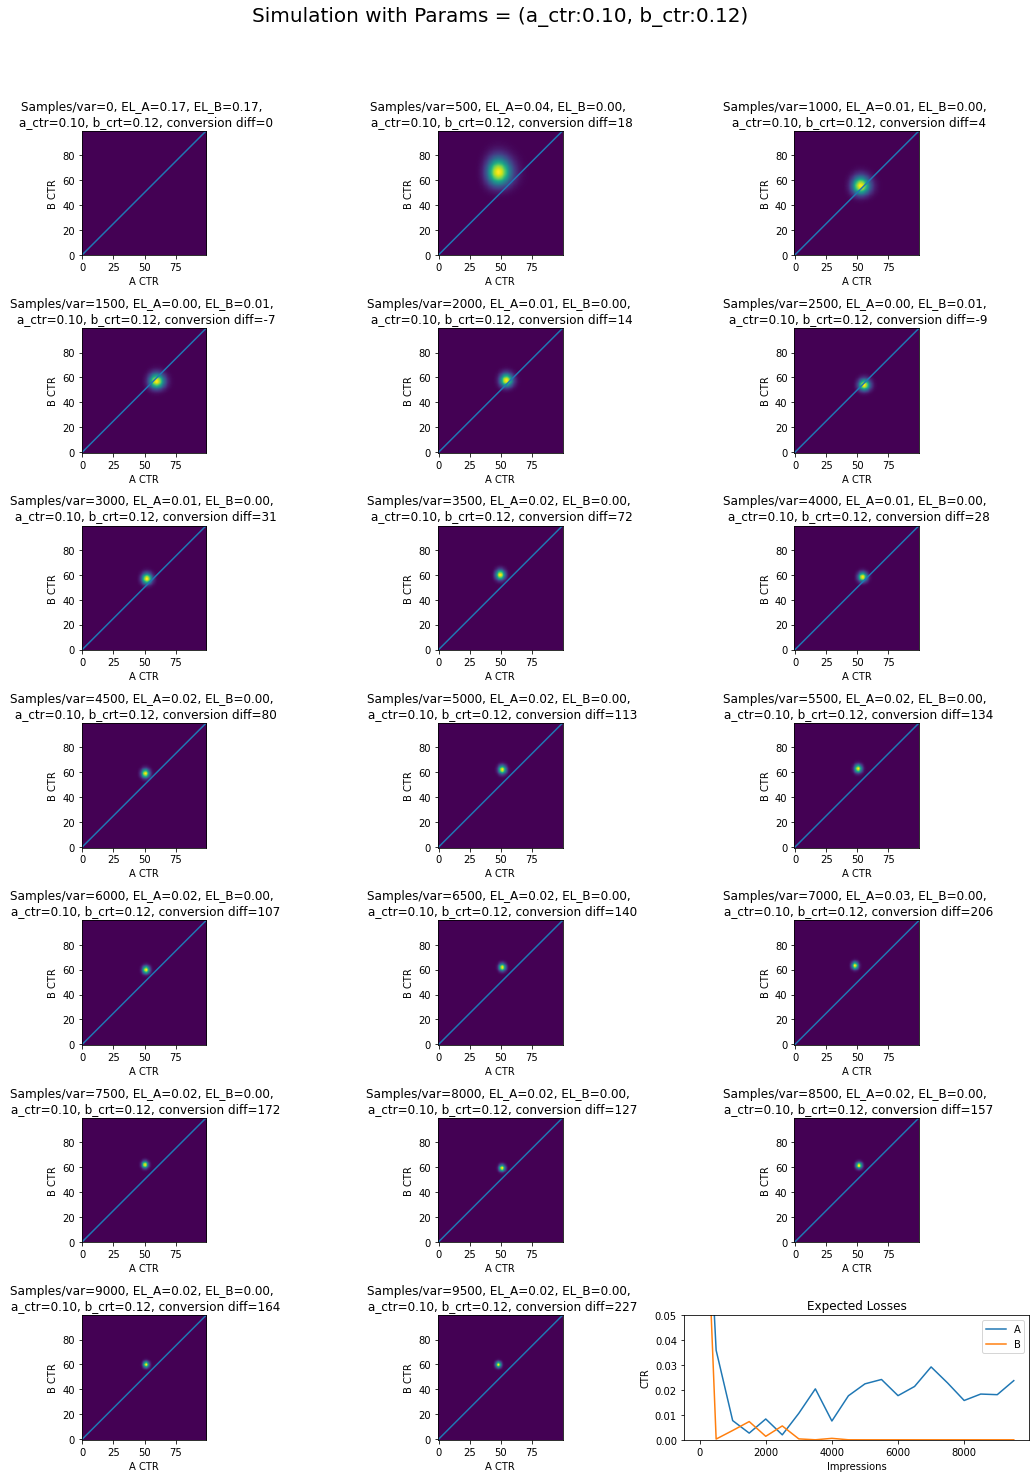

In [203]:
simulate(baseline_ctr=0.1, lift=0.20)

In [ ]:
simulate(baseline_ctr=0.1, lift=0.03, step=5000)